In [1]:
from fastai.vision.all import *

In [3]:
path = untar_data(URLs.PASCAL_2007)

In [4]:
path.ls()

(#8) [Path('/home/ec2-user/.fastai/data/pascal_2007/test.csv'),Path('/home/ec2-user/.fastai/data/pascal_2007/test'),Path('/home/ec2-user/.fastai/data/pascal_2007/segmentation'),Path('/home/ec2-user/.fastai/data/pascal_2007/test.json'),Path('/home/ec2-user/.fastai/data/pascal_2007/train.csv'),Path('/home/ec2-user/.fastai/data/pascal_2007/train.json'),Path('/home/ec2-user/.fastai/data/pascal_2007/valid.json'),Path('/home/ec2-user/.fastai/data/pascal_2007/train')]

In [5]:
imgs, lbl_bbox = get_annotations(path/'train.json')

In [6]:
imgs[0]

'000012.jpg'

In [7]:
lbl_bbox[0]


([[155, 96, 351, 270]], ['car'])

In [8]:
img2bbox = dict(zip(imgs, lbl_bbox))

In [9]:
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first


{'000012.jpg': ([[155, 96, 351, 270]], ['car'])}

In [10]:
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]

In [11]:
item_tfms = [Resize(128, method='pad'),]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [12]:
def get_train_imgs(noop):  return imgs

In [13]:
pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs,
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [14]:
dls = pascal.dataloaders(path/'train')

In [15]:
dls.c = 20

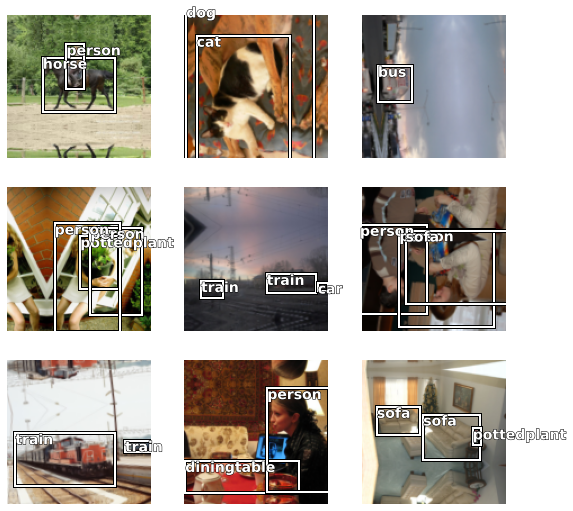

In [16]:
dls.show_batch()


In [18]:
from wwf.vision.object_detection import *


In [19]:
encoder = create_body(resnet34, pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [20]:
get_c(dls)

20

In [21]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)


In [22]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=248, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

In [23]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [24]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [25]:
arch.box_regressor


Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [32]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

In [33]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

In [34]:
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [41]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [42]:
learn.freeze()

In [43]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time


TypeError: __call__() takes 3 positional arguments but 4 were given